In [1]:
%load_ext autoreload
%autoreload 2

import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import theano

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import mb.modelbase as mbase
import mb.pymc3
from mb.pymc3 import ProbabilisticPymc3Model as Pymc3Model

# goal of modeling: predict mpg of cars

Let's try to predict the mpg, that is miles per gallon, of the cars. For that we will use the well-known mpg data set. It is conviniently included in modelbase's data subpackage.


In [2]:
import mb.data
data = mb.data.mpg.cg_4cat3cont()
data.head()

,transmission,cylinder,car_size,year,mpg_city,mpg_highway,displacement
0,auto,few,small,1985,17.0,17.0,2.2960
1,auto,few,small,1985,17.0,17.0,2.2960
2,lock-up,medium,small,1985,21.0,27.0,2.4436
3,lock-up,medium,small,1985,18.0,24.0,2.6896
4,manual,medium,small,1985,18.0,23.0,2.6896


There is two observed variables for mpg: within a city and on a highway. Lets model the mpg in a city for now, that is the variable `mpg_city`.

## data exploration

First, we setup an folder in which we will store models:

In [3]:
models_path = './pymc3_modeling_examples'
import os
if not os.path.exists(models_path):
    os.makedirs(models_path)

Now we can use Lumen for data exploration by wrapping the data in an empirical model:

In [4]:
model_empirical = mbase.model_fitting.make_empirical_model(
    modelname='mpg_empirical01',
    output_directory=models_path, 
    df=data,
    model_type='empirical'
)

We can now explore the data in Lumen, and get some ideas how to model the cars gas consumption.
In particular we learn that the empirical mean is about 17.2.

For a start we could simply model `mpg_city` using a normal distribution, as the marginal empiricial distribution appears unimodal and somehow symmetric:

<img src="img_pymc3_modeling_examples/00_mpg_city_empirical.png" width="400">



## Model 01: simple Gaussian

The histogram over mpg looks roughly normal, so lets start with this very simple model. 
In PyMC3 we write it like this:

In [5]:
# subset data
data01 = data.loc[:,['mpg_city']]
data01.head()

,mpg_city
0,17.0
1,17.0
2,21.0
3,18.0
4,18.0


In [6]:
model01 = pm.Model()
model_name = "model01"

# declare model with PyMC3
with model01:
    
    # pior for mu
    # alternatively we could also use a very uninformative prior such as: mu = pm.Normal('mu', mu=0, sd=100)    
    mu = pm.Normal('mu', mu=17.2, sd=3)
    
    # prior for sigmal
    sd = pm.Normal('sd', mu=3, sd=1)
    
    # likelihood
    mpg_city = pm.Normal('mpg_city', mu=mu, sd=sd, observed=data['mpg_city'])    

In [7]:
# wrap to Lumen, sample from it, and save model to make explorable
model = Pymc3Model(model_name, model01)\
   .fit(data01)\
   .save(models_path)

Auto-assigning NUTS sampler...
16:56:25.835 INFO :: Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
16:56:25.837 INFO :: Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
16:56:27.345 INFO :: Sequential sampling (1 chains in 1 job)
NUTS: [sd, mu]
16:56:27.346 INFO :: NUTS: [sd, mu]
Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 9 seconds.
16:56:36.494 INFO :: Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
16:56:39.114 INFO :: Only one chain was sampled, this makes it impossible to run some convergence checks


Let's check convergence with a trace plot:

/home/luca_ph/venv/modelbase_venv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52daae4748>,
      dtype=object)

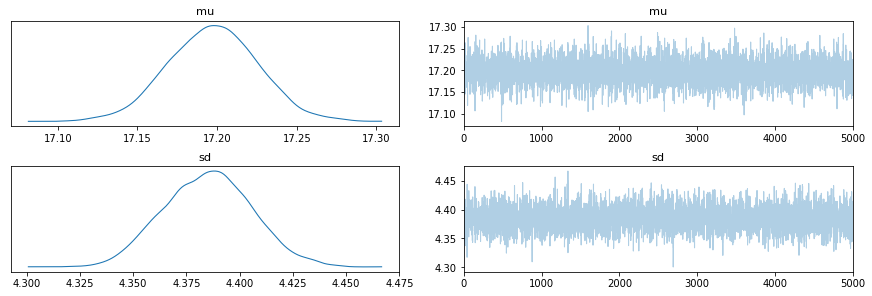

In [8]:
az.plot_trace(model._sample_trace)

The fit of the posterior predictive distribution for `mpg_city` seems not such bad fit to the histogram of the data:

<img src="img_pymc3_modeling_examples/01_mpg_city.png" width="400">

But let's see if we can improve the model by incooperating the categorical variable `cylinders` into it. This is not only informed by our 'expert/common knowledege' but also strongly indicated by the data itself:

<img src="img_pymc3_modeling_examples/01_mpg_city_vs_cylinders.png" width="500">

Here you can clearly see that the value of `cylinder` is strongly correlated to `mpg_city`.

## model 02: non-hierarchical model over car size using cylinders

In the following (model 02) we will first build a model, such that each each cylinder value has its own set of entirely independent Gaussian parameters. Later (model 03) we will make it a true hierarchical model, that is, these Gaussian parameter will be 'connected' by drawing them from a common 'meta distribution'.But first things first.

In [15]:
# subset data
data02 = data.loc[:,['mpg_city', 'cylinder']].copy()
data02.head()

,mpg_city,cylinder
0,17.0,few
1,17.0,few
2,21.0,medium
3,18.0,medium
4,18.0,medium


To work with categorical in PyMC3 we need them to be represented as numbers. To make the conversion more convinient, and in particular let Lumen still print the values as strings instead of hard-to-interpret numbers we can use the `DataTypeMapper` class.

In [16]:
dtm = mbase.utils.DataTypeMapper()
dtm.set_map('cylinder', forward={'few': 0, 'medium': 1, 'many': 2}, backward='auto')
print(dtm)

Forwarding: 
cylinder -> {'few': 0, 'medium': 1, 'many': 2}
Backwarding: 
cylinder -> {0: 'few', 1: 'medium', 2: 'many'}


In [17]:
cylinder = dtm.forward(data.cylinder, inplace=False)
n_cylinder = len(cylinder.unique())
print(cylinder)

0        0
1        0
2        1
3        1
4        1
        ..
23532    2
23533    1
23534    1
23535    1
23536    1
Name: cylinder, Length: 23537, dtype: int64


In [18]:
model02 = pm.Model()
model_name = "model02"

with model02:      
    # uninformative prior for groups. we could very well use informed priors according to
    # the empirical means of the groups
    mu_cylinder = pm.Normal("mu_cylinder", mu=0, sigma=100, shape = n_cylinder)
    
    # deterministic grouping variables
    mean_by_cyl_groups = mu_cylinder[cylinder]
    
    # prior for model error / standard deviation
    sd = pm.Normal('sd', mu=3, sd=2)
    
    # likelihood    
    mpg_city = pm.Normal('mpg_city', mu=mean_by_cyl_groups, sd=sd, observed=data02.mpg_city)

In [19]:
# for technical reasons it is neccesary to provide independent variables as theano shared variables to Lumen
theano_shared = {'cylinder': theano.shared(cylinder)}

# wrap to Lumen
model = Pymc3Model(model_name, model02, shared_vars=theano_shared, data_mapping=dtm)\
                 .fit(data02)\
                 .save(models_path)

/home/luca_ph/venv/modelbase_venv/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
14:40:24.997 INFO :: Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
14:40:24.998 INFO :: Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
14:40:26.108 INFO :: Sequential sampling (1 chains in 1 job)
NUTS: [sd, mu_cylinder]
14:40:26.110 INFO :: NUTS: [sd, mu_cylinder]
Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 23 seconds.
14:40:49.396 INFO :: Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some conve

14:41:05.403 WARNING :: failed to automatically determine extent of field "mpg_city".
14:41:05.408 WARNING :: failed to automatically determine extent of field "sd".
14:41:05.413 WARNING :: failed to automatically determine extent of field "mu_cylinder_0".
14:41:05.416 WARNING :: failed to automatically determine extent of field "mu_cylinder_1".
14:41:05.421 WARNING :: failed to automatically determine extent of field "mu_cylinder_2".


Let's check convergence here too

/home/luca_ph/venv/modelbase_venv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22244150b8>,
      dtype=object)

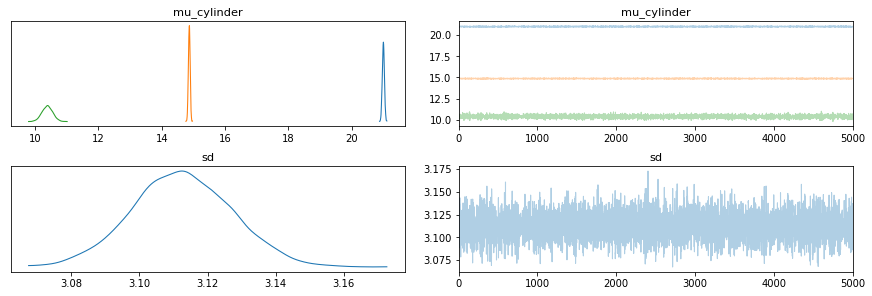

In [20]:
az.plot_trace(model._samples_trace)

In Lumen we can check the model. For instance we can compare the posterior predictive distribution with the data distribution. We learn that the posterior is a bit right skewed wrt to the data, and also the mean of the model has a too high value.

<img src="img_pymc3_modeling_examples/02_mpg_city.png" width="400">

It's also quite interesting to see that the model correctly recovered the group means, even though we used an uninformative prior for it. Here `mu_cylinder_[0,1,2]` refers to `few`, `medium` and `many` cylinders.

<img src="img_pymc3_modeling_examples/03_recovered_group_means.png" width="600">



## Model 03: hierarchical model with common distribution for group parameters

So, let's try to improve the model by using a common distributon for the cylinder group means:

In [21]:
# data: reuse data02, it is unchanged

In [22]:
model_name = "model03"
#model_description = "..."
model03 = pm.Model()

#with model03 = pm.Model():           
with model03:

    #TODO add common hyper distribution for groups and adapt sigma prior to half-normal since it cannot be <=0
    
    # hierarchical prior for mean mpg_city depending on cylinders  
    
    prior_mu = pm.Normal('prior_mu', mu=17.2, sigma=10)    
    prior_sigma = pm.TruncatedNormal('prior_sigma', mu=3, sd=2, lower=0.01)
    
    hyper_cyl_mu = pm.Normal('hyper_cyl_mu', mu=prior_mu, sigma=prior_sigma)    
    
    # uninformative prior for groups
    mu_cylinder = pm.Normal("mu_cylinder", mu=hyper_cyl_mu, sigma=100, shape=n_cylinder)
    
    # deterministic grouping variables
    mean_by_cyl_groups = mu_cylinder[cylinder]
    
    # cylinders = pm.Categorical("")
    # mu = pm.Normal('mu', mu=, sd=100)    
    
    # prior for standard deviation of model error
    sd = pm.TruncatedNormal('sd', mu=3, sd=2, lower=0.01)
    
    # likelihood    
    mpg_city = pm.Normal('mpg_city', mu=mean_by_cyl_groups, sd=sd, observed=data02.mpg_city)

In [23]:
theano_shared = {'cylinder': theano.shared(cylinder)}

# wrap to Lumen
model = Pymc3Model(model_name, model03, shared_vars=theano_shared, data_mapping=dtm)\
                 .fit(data02)\
                 .save(models_path)

/home/luca_ph/venv/modelbase_venv/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
14:42:18.713 INFO :: Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
14:42:18.715 INFO :: Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
14:42:21.937 INFO :: Sequential sampling (1 chains in 1 job)
NUTS: [sd, mu_cylinder, hyper_cyl_mu, prior_sigma, prior_mu]
14:42:21.940 INFO :: NUTS: [sd, mu_cylinder, hyper_cyl_mu, prior_sigma, prior_mu]
Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 77 seconds.
14:43:38.943 INFO :: Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 77 secon

14:43:55.817 WARNING :: failed to automatically determine extent of field "mpg_city".
14:43:55.827 WARNING :: failed to automatically determine extent of field "prior_mu".
14:43:55.835 WARNING :: failed to automatically determine extent of field "prior_sigma_lowerbound__".
14:43:55.849 WARNING :: failed to automatically determine extent of field "hyper_cyl_mu".
14:43:55.863 WARNING :: failed to automatically determine extent of field "sd_lowerbound__".
14:43:55.881 WARNING :: failed to automatically determine extent of field "prior_sigma".
14:43:55.892 WARNING :: failed to automatically determine extent of field "sd".
14:43:55.900 WARNING :: failed to automatically determine extent of field "mu_cylinder_0".
14:43:55.906 WARNING :: failed to automatically determine extent of field "mu_cylinder_1".
14:43:55.915 WARNING :: failed to automatically determine extent of field "mu_cylinder_2".


/home/luca_ph/venv/modelbase_venv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2218519a90>,
      dtype=object)

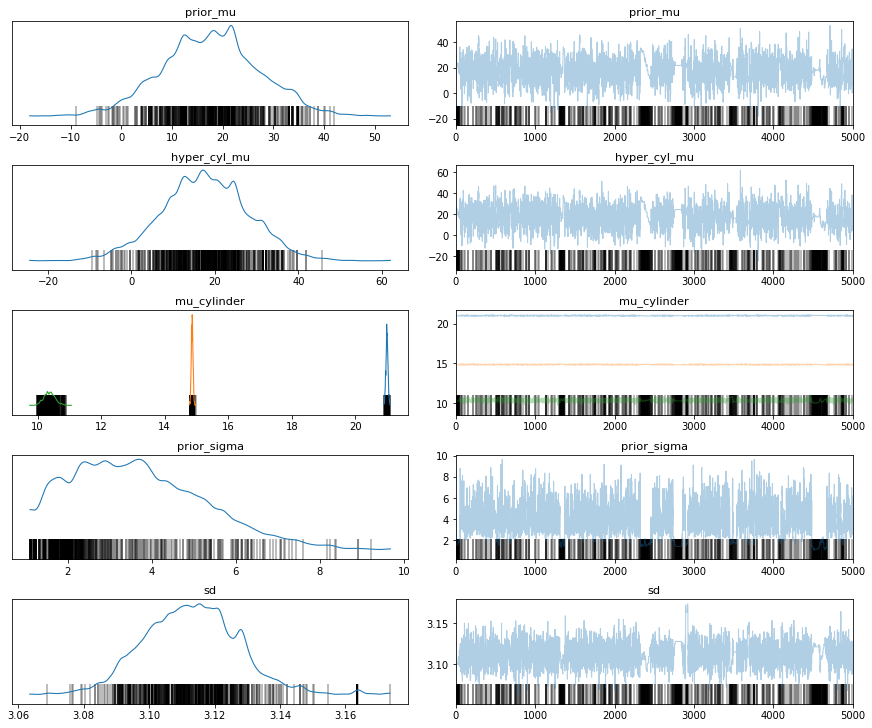

In [24]:
az.plot_trace(model._samples_trace)

In [24]:
data03 = data.copy()
data03.displacement = np.log(data03.displacement)

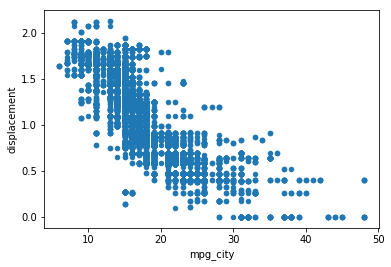

In [47]:
data03.plot.scatter(x='mpg_city', y='displacement')

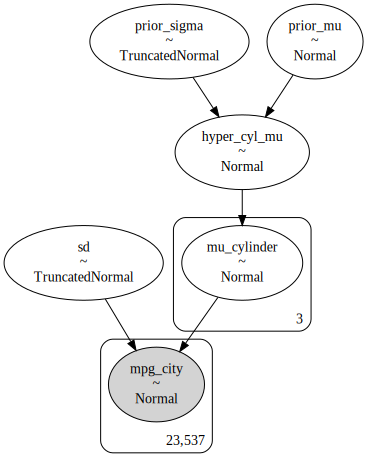

In [26]:
pm.model_to_graphviz(model.model_structure)